In [1]:
import logging
logging.getLogger('tensorflow').disabled = True
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # remove WARNING Messages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
# parameter class fis parameters


class fis_parameters:
    def __init__(self, n_input: int = 3, n_memb: int = 3, batch_size: int = 16, n_epochs: int = 25, memb_func: str = 'gaussian', optimizer: str = 'sgd', loss: str = 'mse'):
        """
        Initializes parameters for a fuzzy inference system.

        Args:
            n_input (int): Number of regressors, representing the input dimensions.
            n_memb (int): Number of fuzzy memberships, determining the granularity of membership functions.
            batch_size (int): Size of batches to be used during training.
            n_epochs (int): Number of epochs, indicating the number of times the learning algorithm will work through the entire training dataset.
            memb_func (str): Type of membership function to be used, e.g., 'gaussian' or 'gbellmf'.
            optimizer (str): Optimization algorithm, such as 'sgd' (Stochastic Gradient Descent) or 'adam'.
            loss (str): Loss function to be minimized during training, e.g., 'mse' (Mean Squared Error) or 'mae' (Mean Absolute Error).
        """
        self.n_input = n_input
        self.n_memb = n_memb
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.memb_func = memb_func
        self.optimizer = optimizer
        self.loss = loss


# Main Class ANFIS
class ANFIS:
    def __init__(self, n_input: int, n_memb: int, batch_size: int = 16, memb_func: str = 'gaussian', name: str = 'MyAnfis'):
        """
        Initializes an Adaptive Neuro-Fuzzy Inference System (ANFIS) model.

        Args:
            n_input (int): Number of input features.
            n_memb (int): Number of fuzzy memberships.
            batch_size (int, optional): Size of batches for training. Defaults to 16.
            memb_func (str, optional): Type of membership function, e.g., 'gaussian'. Defaults to 'gaussian'.
            name (str, optional): Name of the ANFIS model. Defaults to 'MyAnfis'.
        """
        self.n = n_input
        self.m = n_memb
        self.batch_size = batch_size
        self.memb_func = memb_func
        input_ = keras.layers.Input(
            shape=(n_input,), name='inputLayer', batch_size=self.batch_size)
        L1 = FuzzyLayer(n_input, n_memb, memb_func, name='fuzzyLayer')(input_)
        L2 = RuleLayer(n_input, n_memb, name='ruleLayer')(L1)
        L3 = NormLayer(name='normLayer')(L2)
        L4 = DefuzzLayer(n_input, n_memb, name='defuzzLayer')(L3, input_)
        L5 = SummationLayer(name='sumLayer')(L4)
        self.model = keras.Model(inputs=[input_], outputs=[L5], name=name)
        self.update_weights()

    def __call__(self, X):
        """
        Makes predictions using the ANFIS model.

        Args:
            X (numpy.ndarray): Input data.

        Returns:
            numpy.ndarray: Predicted values.
        """
        return self.model.predict(X, batch_size=self.batch_size)

    def update_weights(self):
        """
        Updates the weights of the ANFIS model.

        This function retrieves and updates the premise and consequence parameters based on the membership function type.
        """
        # premise parameters (mu&sigma for gaussian // a/b/c for bell-shaped)
        if self.memb_func == 'gaussian':
            self.mus, self.sigmas = self.model.get_layer(
                'fuzzyLayer').get_weights()
        elif self.memb_func == 'gbellmf':
            self.a, self.b, self.c = self.model.get_layer(
                'fuzzyLayer').get_weights()
        # consequence parameters
        self.bias, self.weights = self.model.get_layer(
            'defuzzLayer').get_weights()

    def plotmfs(self, show_initial_weights=False):
        """
        Plots the membership functions of the ANFIS model.

        Args:
            show_initial_weights (bool, optional): Whether to show the initial weights. Defaults to False.
        """
        n_input = self.n
        n_memb = self.m

        if self.memb_func == 'gaussian':
            mus, sigmas = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            mus, sigmas = mus.reshape(
                (n_memb, n_input, 1)), sigmas.reshape(n_memb, n_input, 1)

            xn = np.linspace(np.min(mus) - 2 * np.max(abs(sigmas)),
                             np.max(mus) + 2 * np.max(abs(sigmas)), 100).reshape((1, 1, -1))
            xn = np.tile(xn, (n_memb, n_input, 1))

            # broadcast all curves in one array
            memb_curves = np.exp(-np.square((xn - mus)) / np.square(sigmas))

            if show_initial_weights:
                mus_init, sigmas_init = np.around(self.init_weights, 2)
                mus_init, sigmas_init = mus_init.reshape(
                    n_memb, n_input, 1), sigmas_init.reshape(n_memb, n_input, 1)
                init_curves = np.exp(-np.square((xn - mus_init)
                                                ) / np.square(sigmas_init))

        elif self.memb_func == 'gbellmf':
            a, b, c = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            a, b, c = a.reshape((n_memb, n_input, 1)), b.reshape(
                n_memb, n_input, 1), c.reshape(n_memb, n_input, 1)

            xn = np.linspace(np.min(c) - 2 * np.max(abs(a)),
                             np.max(c) + 2 * np.max(abs(a)), 100).reshape((1, 1, -1))
            xn = np.tile(xn, (n_memb, n_input, 1))

            # broadcast all curves in one array
            memb_curves = 1 / (1 + np.square((xn - c) / a)**b)

            if show_initial_weights:
                a_init, b_init, c_init = np.around(self.init_weights, 2)
                a_init, b_init, c_init = a_init.reshape((n_memb, n_input, 1)), b_init.reshape(
                    n_memb, n_input, 1), c_init.reshape(n_memb, n_input, 1)
                init_curves = 1 / \
                    (1 + np.square((xn - c_init) / a_init)**b_init)

        elif self.memb_func == 'sigmoid':
            gammas, c = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            gammas, c = gammas.reshape(
                (n_memb, n_input, 1)), c.reshape(n_memb, n_input, 1)

            xn = np.linspace(np.min(c) - 2 * np.max(abs(c)), np.max(c) + 2 * np.max(
                abs(c)), 100).reshape((1, 1, -1))  # TODO: change confidence bands
            xn = np.tile(xn, (n_memb, n_input, 1))

            # broadcast all curves in one array
            memb_curves = 1 / (1 + np.exp(-gammas * (xn - c)))

            if show_initial_weights:
                gammas_init, c_init = np.around(self.init_weights, 2)
                gammas_init, c_init = gammas_init.reshape(
                    n_memb, n_input, 1), c_init.reshape(n_memb, n_input, 1)
                init_curves = 1 / (1 + np.exp(-gammas_init * (xn - c_init)))

        fig, axs = plt.subplots(nrows=n_input, ncols=1, figsize=(8, self.n * 3))
        fig.suptitle('Membership functions', size=16)
        for n in range(self.n):
            axs[n].grid(True)
            axs[n].set_title(f'Input {n+1}')
            for m in range(self.m):
                axs[n].plot(xn[m, n, :], memb_curves[m, n, :])

        if show_initial_weights:  # plot initial membership curve
            for n in range(self.n):
                axs[n].set_prop_cycle(None)  # reset color cycle
                for m in range(self.m):
                    axs[n].plot(xn[m, n, :], init_curves[m, n, :],
                                '--', alpha=.5)
        plt.show()

    def fit(self, X, y, **kwargs):
        """
        Fits the ANFIS model to the training data.

        Args:
            X (numpy.ndarray): Input data.
            y (numpy.ndarray): Target data.
            **kwargs: Additional arguments for training.

        Returns:
            History: A History object containing training metrics.
        """
        # save initial weights in the anfis class
        self.init_weights = self.model.get_layer('fuzzyLayer').get_weights()

        # fit model & update weights in the anfis class
        history = self.model.fit(X, y, **kwargs)
        self.update_weights()

        # clear the graphs
        tf.keras.backend.clear_session()

        return history

    def get_memberships(self, Xs):
        """
        Computes the membership values for input data.

        Args:
            Xs (numpy.ndarray): Input data.

        Returns:
            numpy.ndarray: Membership values.
        """
        intermediate_layer_model = keras.Model(inputs=self.model.input,
                                               outputs=self.model.get_layer('normLayer').output)

        intermediate_L2_output = intermediate_layer_model.predict(Xs)

        return intermediate_L2_output


# Custom weight initializer
def equally_spaced_initializer(shape, minval=-1.5, maxval=1.5, dtype=tf.float32):
    """
    Custom weight initializer:
        euqlly spaced weights along an operating range of [minval, maxval].
    """
    linspace = tf.reshape(tf.linspace(minval, maxval, shape[0]),
                          (-1, 1))
    return tf.Variable(tf.tile(linspace, (1, shape[1])))


# Layer 1
class FuzzyLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, memb_func='gaussian', **kwargs):
        """
        Initializes a Fuzzy Layer.

        Args:
            n_input (int): Number of input features.
            n_memb (int): Number of fuzzy memberships.
            memb_func (str, optional): Type of membership function. Defaults to 'gaussian'.
            **kwargs: Additional keyword arguments.
        """
        super(FuzzyLayer, self).__init__(**kwargs)
        self.n = n_input
        self.m = n_memb
        self.memb_func = memb_func

    def build(self, batch_input_shape):
        """
        Builds the Fuzzy Layer.

        Args:
            batch_input_shape (tuple): Batch input shape.
        """
        self.batch_size = batch_input_shape[0]

        if self.memb_func == 'gbellmf':
            self.a = self.add_weight(name='a',
                                     shape=(self.m, self.n),
                                     initializer=keras.initializers.RandomUniform(
                                         minval=.7, maxval=1.3, seed=1),
                                     #initializer = 'ones',
                                     trainable=True)
            self.b = self.add_weight(name='b',
                                     shape=(self.m, self.n),
                                     initializer=keras.initializers.RandomUniform(
                                         minval=.7, maxval=1.3, seed=1),
                                     #initializer = 'ones',
                                     trainable=True)
            self.c = self.add_weight(name='c',
                                     shape=(self.m, self.n),
                                     initializer=equally_spaced_initializer,
                                     #initializer = keras.initializers.RandomUniform(minval=-1.5, maxval=1.5, seed=1),
                                     #initializer = 'zeros',
                                     trainable=True)

        elif self.memb_func == 'gaussian':
            self.mu = self.add_weight(name='mu',
                                      shape=(self.m, self.n),
                                      initializer=equally_spaced_initializer,
                                      #initializer = keras.initializers.RandomUniform(minval=-1.5, maxval=1.5, seed=1),
                                      #initializer = 'zeros',
                                      trainable=True)
            self.sigma = self.add_weight(name='sigma',
                                         shape=(self.m, self.n),
                                         initializer=keras.initializers.RandomUniform(
                                             minval=.7, maxval=1.3, seed=1),
                                         #initializer = 'ones',
                                         trainable=True)

        elif self.memb_func == 'sigmoid':
            self.gamma = self.add_weight(name='gamma',
                                         shape=(self.m, self.n),
                                         initializer=equally_spaced_initializer,  # 'ones',
                                         trainable=True)

            self.c = self.add_weight(name='c',
                                     shape=(self.m, self.n),
                                     initializer=equally_spaced_initializer,  # 'ones',
                                     trainable=True)

        # Be sure to call this at the end
        super(FuzzyLayer, self).build(batch_input_shape)

    def call(self, x_inputs):
        """
        Computes the output of the Fuzzy Layer.

        Args:
            x_inputs (tensor): Input tensor.

        Returns:
            tensor: Output tensor.
        """
        if self.memb_func == 'gbellmf':
            L1_output = 1 / (1 +
                             tf.math.pow(
                                 tf.square(tf.subtract(
                                     tf.reshape(
                                         tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.c
                                 ) / self.a), self.b)
                             )
        elif self.memb_func == 'gaussian':
            L1_output = tf.exp(-1 *
                               tf.square(tf.subtract(
                                   tf.reshape(
                                       tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.mu
                               )) / tf.square(self.sigma))

        elif self.memb_func == 'sigmoid':
            L1_output = tf.math.divide(1,
                                       tf.math.exp(-self.gamma *
                                                   tf.subtract(
                                                       tf.reshape(
                                                           tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.c)
                                                   )
                                       )
        return L1_output


# Layer 2
class RuleLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, **kwargs):
        """
        Initializes a Rule Layer.

        Args:
            n_input (int): Number of input features.
            n_memb (int): Number of fuzzy memberships.
            **kwargs: Additional keyword arguments.
        """
        super(RuleLayer, self).__init__(**kwargs)
        self.n = n_input
        self.m = n_memb
        self.batch_size = None

    def build(self, batch_input_shape):
        """
        Builds the Rule Layer.

        Args:
            batch_input_shape (tuple): Batch input shape.
        """
        self.batch_size = batch_input_shape[0]
        # self.batch_size = tf.shape(batch_input_shape)[0]
        # Be sure to call this at the end
        super(RuleLayer, self).build(batch_input_shape)

    def call(self, input_):
        """
        Computes the output of the Rule Layer.

        Args:
            input_ (tensor): Input tensor.

        Returns:
            tensor: Output tensor.
        """
        if self.n == 2:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1])
        elif self.n == 3:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1])
        elif self.n == 4:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1])
        elif self.n == 5:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 4], [self.batch_size, 1, 1, 1, 1, -1])
        elif self.n == 6:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 4], [self.batch_size, 1, 1, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 5], [
                           self.batch_size, 1, 1, 1, 1, 1, -1])
        else:
            raise ValueError(
                f'This ANFIS implementation works with 2 to 6 inputs.')

        return tf.reshape(L2_output, [self.batch_size, -1])


# Layer 3
class NormLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        """
        Initializes a Normalization Layer.

        Args:
            **kwargs: Additional keyword arguments.
        """
        super().__init__(**kwargs)

    def call(self, w):
        """
        Computes the output of the Normalization Layer.

        Args:
            w (tensor): Input tensor.

        Returns:
            tensor: Output tensor.
        """
        w_sum = tf.reshape(tf.reduce_sum(w, axis=1), (-1, 1))
        w_norm = w / w_sum
        return w_norm


# Layer 4
class DefuzzLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, **kwargs):
        """
        Initializes a Defuzzification Layer.

        Args:
            n_input (int): Number of input features.
            n_memb (int): Number of fuzzy memberships.
            **kwargs: Additional keyword arguments.
        """
        super().__init__(**kwargs)
        self.n = n_input
        self.m = n_memb

        self.CP_bias = self.add_weight(name='Consequence_bias',
                                       shape=(1, self.m ** self.n),
                                       initializer=keras.initializers.RandomUniform(
                                           minval=-2, maxval=2),
                                       # initializer = 'ones',
                                       trainable=True)
        self.CP_weight = self.add_weight(name='Consequence_weight',
                                         shape=(self.n, self.m ** self.n),
                                         initializer=keras.initializers.RandomUniform(
                                             minval=-2, maxval=2),
                                         # initializer = 'ones',
                                         trainable=True)

    def call(self, w_norm, input_):
        """
        Computes the output of the Defuzzification Layer.

        Args:
            w_norm (tensor): Normalized weights tensor.
            input_ (tensor): Input tensor.

        Returns:
            tensor: Output tensor.
        """
        L4_L2_output = tf.multiply(w_norm,
                                   tf.matmul(input_, self.CP_weight) + self.CP_bias)
        return L4_L2_output  # Defuzzyfied Layer


# Layer 5
class SummationLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        """
        Initializes a Summation Layer.

        Args:
            **kwargs: Additional keyword arguments.
        """
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        """
        Builds the Summation Layer.

        Args:
            batch_input_shape (tuple): Batch input shape.
        """
        self.batch_size = batch_input_shape[0]
        # Be sure to call this at the end
        super(SummationLayer, self).build(batch_input_shape)

    def call(self, input_):
        """
        Computes the output of the Summation Layer.

        Args:
            input_ (tensor): Input tensor.

        Returns:
            tensor: Output tensor.
        """
        L5_L2_output = tf.reduce_sum(input_, axis=1)
        L5_L2_output = tf.reshape(L5_L2_output, (-1, 1))
        return L5_L2_output


In [2]:
import pandas as pd
import numpy as np
import sys
sys.maxsize

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

In [3]:
df = pd.read_excel('Capacitive Deionization.xlsx') 
df.shape

Defaulting to user installation because normal site-packages is not writeable


(125, 5)

In [6]:
df.head()

,volt(V),concentrate(ppm),feed rate(ml/min),EC(μmho/cm),Desalination(%)
0,0.8,1000,10,1660.0,0.170
1,0.8,1000,20,1690.0,0.155
2,0.8,1000,30,1730.0,0.135
3,0.8,1000,40,1780.0,0.110
4,0.8,1000,50,1810.0,0.095


In [7]:
df.describe()

,volt(V),concentrate(ppm),feed rate(ml/min),EC(μmho/cm),Desalination(%)
count,125.000000,125.000000,125.000000,125.000000,125.000000
mean,1.200000,3000.000000,30.000000,5048.720000,0.158772
std,0.283981,1419.904586,14.199046,2393.276529,0.022901
min,0.800000,1000.000000,10.000000,1560.000000,0.095000
25%,1.000000,2000.000000,20.000000,3310.000000,0.145000
50%,1.200000,3000.000000,30.000000,4970.000000,0.161250
75%,1.400000,4000.000000,40.000000,7000.000000,0.173333
max,1.600000,5000.000000,50.000000,8490.000000,0.220000


In [8]:
scaler=MinMaxScaler()
df2=scaler.fit_transform(df)
df2

array([[0.        , 0.        , 0.        , 0.01443001, 0.6       ],
       [0.        , 0.        , 0.25      , 0.01875902, 0.48      ],
       [0.        , 0.        , 0.5       , 0.02453102, 0.32      ],
       [0.        , 0.        , 0.75      , 0.03174603, 0.12      ],
       [0.        , 0.        , 1.        , 0.03607504, 0.        ],
       [0.        , 0.25      , 0.        , 0.25541126, 0.58      ],
       [0.        , 0.25      , 0.25      , 0.25974026, 0.52      ],
       [0.        , 0.25      , 0.5       , 0.26406926, 0.46      ],
       [0.        , 0.25      , 0.75      , 0.26984127, 0.38      ],
       [0.        , 0.25      , 1.        , 0.27417027, 0.32      ],
       [0.        , 0.5       , 0.        , 0.48917749, 0.64      ],
       [0.        , 0.5       , 0.25      , 0.49494949, 0.58666667],
       [0.        , 0.5       , 0.5       , 0.50505051, 0.49333333],
       [0.        , 0.5       , 0.75      , 0.51226551, 0.42666667],
       [0.        , 0.5       , 1.

In [10]:
X=df2[:,0:3]
Y=df2[:,-1]

display(X)
display(Y)

array([[0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.25],
       [0.  , 0.  , 0.5 ],
       [0.  , 0.  , 0.75],
       [0.  , 0.  , 1.  ],
       [0.  , 0.25, 0.  ],
       [0.  , 0.25, 0.25],
       [0.  , 0.25, 0.5 ],
       [0.  , 0.25, 0.75],
       [0.  , 0.25, 1.  ],
       [0.  , 0.5 , 0.  ],
       [0.  , 0.5 , 0.25],
       [0.  , 0.5 , 0.5 ],
       [0.  , 0.5 , 0.75],
       [0.  , 0.5 , 1.  ],
       [0.  , 0.75, 0.  ],
       [0.  , 0.75, 0.25],
       [0.  , 0.75, 0.5 ],
       [0.  , 0.75, 0.75],
       [0.  , 0.75, 1.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.25],
       [0.  , 1.  , 0.5 ],
       [0.  , 1.  , 0.75],
       [0.  , 1.  , 1.  ],
       [0.25, 0.  , 0.  ],
       [0.25, 0.  , 0.25],
       [0.25, 0.  , 0.5 ],
       [0.25, 0.  , 0.75],
       [0.25, 0.  , 1.  ],
       [0.25, 0.25, 0.  ],
       [0.25, 0.25, 0.25],
       [0.25, 0.25, 0.5 ],
       [0.25, 0.25, 0.75],
       [0.25, 0.25, 1.  ],
       [0.25, 0.5 , 0.  ],
       [0.25, 0.5 , 0.25],
 

array([0.6       , 0.48      , 0.32      , 0.12      , 0.        ,
       0.58      , 0.52      , 0.46      , 0.38      , 0.32      ,
       0.64      , 0.58666667, 0.49333333, 0.42666667, 0.28      ,
       0.39      , 0.32      , 0.25      , 0.18      , 0.12      ,
       0.6       , 0.568     , 0.536     , 0.496     , 0.448     ,
       0.64      , 0.56      , 0.4       , 0.32      , 0.04      ,
       0.6       , 0.56      , 0.52      , 0.44      , 0.38      ,
       0.68      , 0.62666667, 0.56      , 0.49333333, 0.44      ,
       0.44      , 0.34      , 0.27      , 0.2       , 0.14      ,
       0.632     , 0.608     , 0.56      , 0.528     , 0.488     ,
       0.72      , 0.6       , 0.48      , 0.36      , 0.12      ,
       0.7       , 0.64      , 0.54      , 0.46      , 0.36      ,
       0.72      , 0.66666667, 0.62666667, 0.54666667, 0.46666667,
       0.48      , 0.4       , 0.33      , 0.27      , 0.17      ,
       0.672     , 0.632     , 0.576     , 0.544     , 0.504  

In [11]:
print(Y.shape)
print(X.shape)

(125,)
(125, 3)


In [12]:
param = fis_parameters(
            n_input = 3,                # no. of Regressors
            n_memb = 3,                 # no. of fuzzy memberships
            batch_size = 1,            # 16 / 32 / 64 / ...
            memb_func = 'gaussian',      # 'gaussian' / 'gbellmf' / 'sigmoid'
            optimizer = 'adam',          # sgd / adam / ...
            loss = 'mse',               # mse / mae / huber_loss / mean_absolute_percentage_error / ...
            n_epochs = 50               # 10 / 25 / 50 / 100 / ...
            )

In [13]:
histories=[]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [14]:
# inicialize the model
fis = ANFIS(n_input = param.n_input,
                        n_memb = param.n_memb,
                        batch_size = param.batch_size,
                        memb_func = param.memb_func,
                        name = 'myanfis'
                        )

In [15]:
# compile model
fis.model.compile(optimizer=param.optimizer,
                      loss=param.loss
                      ,metrics=['mae', 'mse']  # ['mae', 'mse']
                      )

In [16]:
# fit model
history = fis.fit(X_train, y_train,
                      epochs=param.n_epochs,
                      batch_size=param.batch_size,
                      validation_data = (X_test, y_test),
                       #callbacks = [tensorboard_callback]  # for tensorboard
                      )
histories.append(history)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4659 - mae: 0.9465 - mse: 1.4659 - val_loss: 1.0565 - val_mae: 0.8719 - val_mse: 1.0565
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 0.9226 - mae: 0.8240 - mse: 0.9226 - val_loss: 0.7904 - val_mae: 0.7404 - val_mse: 0.7904
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.7860 - mae: 0.7608 - mse: 0.7860 - val_loss: 0.6208 - val_mae: 0.6512 - val_mse: 0.6208
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.6967 - mae: 0.7060 - mse: 0.6967 - val_loss: 0.5032 - val_mae: 0.5910 - val_mse: 0.5032
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.4599 - mae: 0.5647 - mse: 0.4599 - val_loss: 0.4199 - val_mae: 0.5467 - val_mse: 0.4199
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 0.4347 - mae: 0.5530 - mse: 0.4347 - val_loss: 0.3519 - val_mae: 0.5025 - val_mse: 0.3519
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 0.3655 - mae: 0.4997 - mse: 0.3655 - val_l

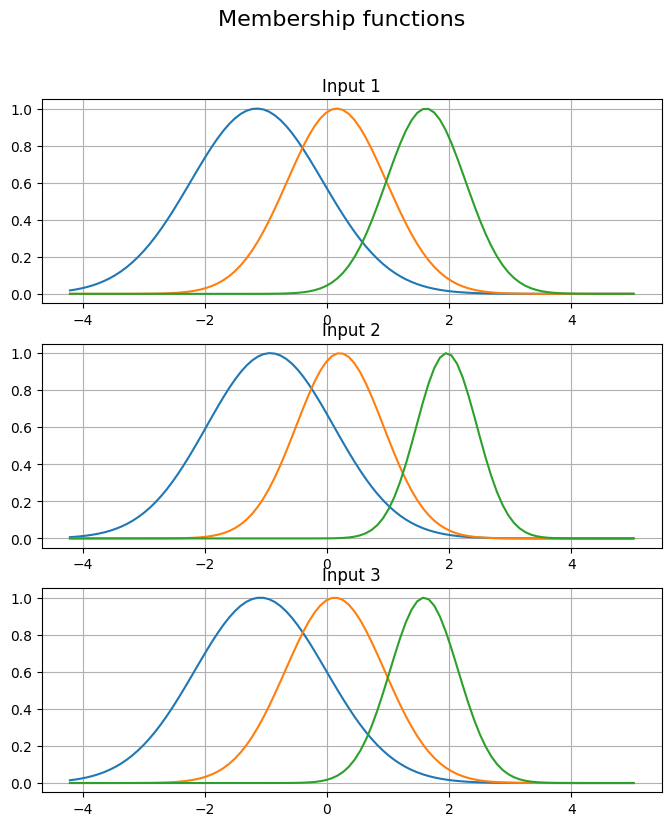

In [19]:
fis.plotmfs()

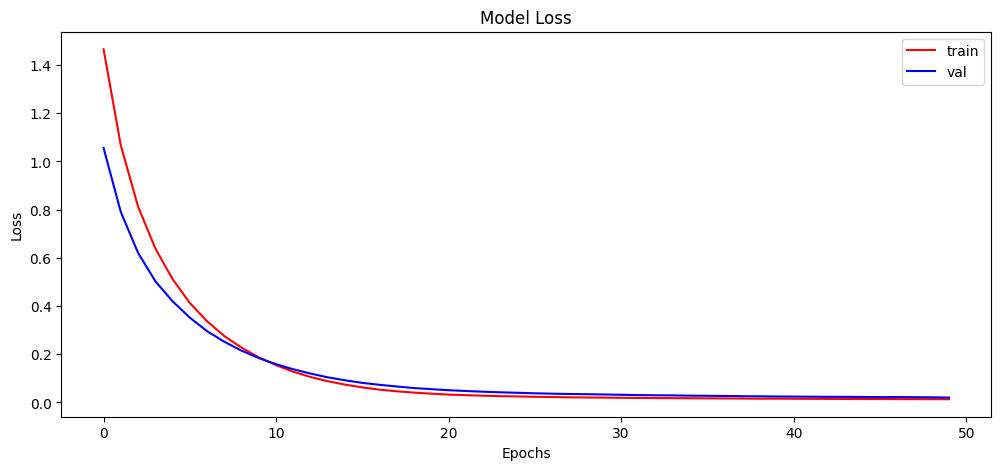

In [20]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

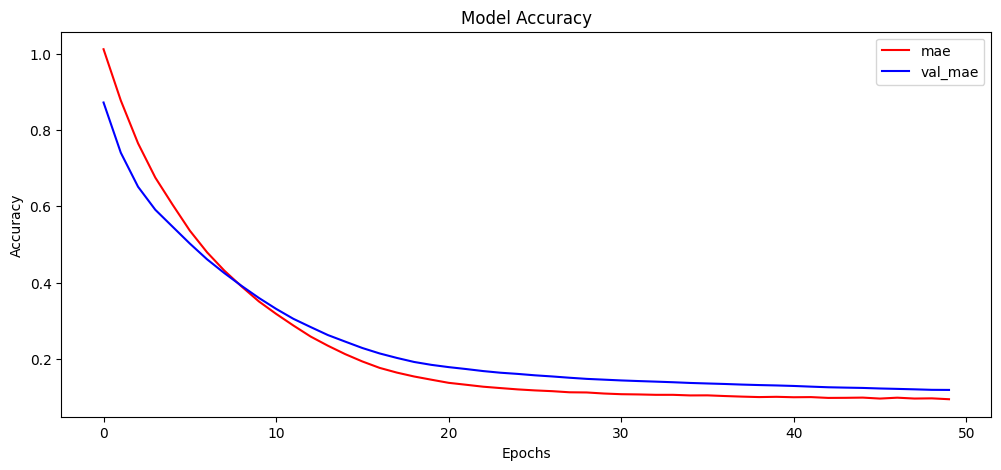

In [21]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['mae'], color='r')
plt.plot(history.history['val_mae'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['mae', 'val_mae'])
plt.show()

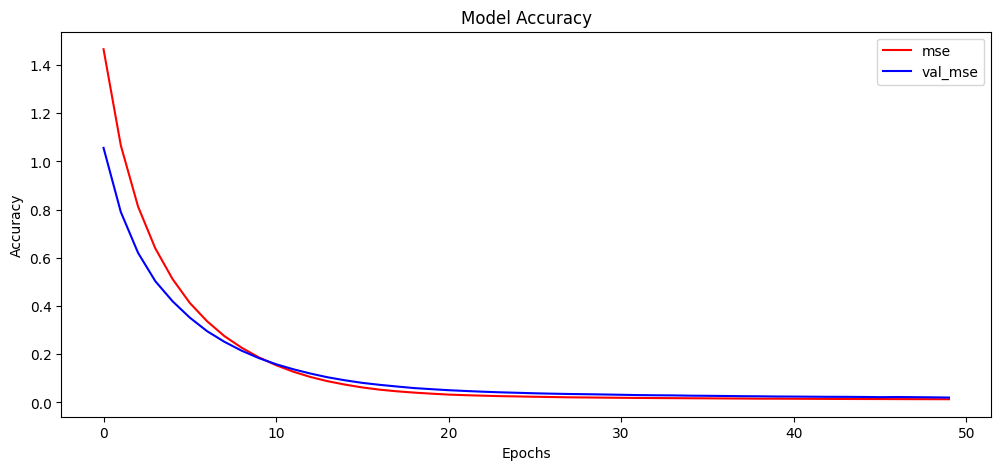

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['mse'], color='r')
plt.plot(history.history['val_mse'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['mse', 'val_mse'])
plt.show()

In [23]:
a=fis.model.summary()


Model: "myanfis"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputLayer          │ (1, 3)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuzzyLayer          │ (1, 3, 3)         │         18 │ inputLayer[0][0]  │
│ (FuzzyLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ruleLayer           │ (1, 27)           │          0 │ fuzzyLayer[0][0]  │
│ (RuleLayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normLayer           │ (1, 27)           │          0 │ ruleLayer[0][0]   │
│ (NormLayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defuzzLayer         │ (1, 27)           │        108 │ normLayer[0][0],  │
│ (DefuzzLayer)       │                   │            │ inputLayer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sumLayer            │ (1, 1)            │          0 │ defuzzLayer[0][0] │
│ (SummationLayer)    │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 380 (1.49 KB)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 254 (1020.00 B)

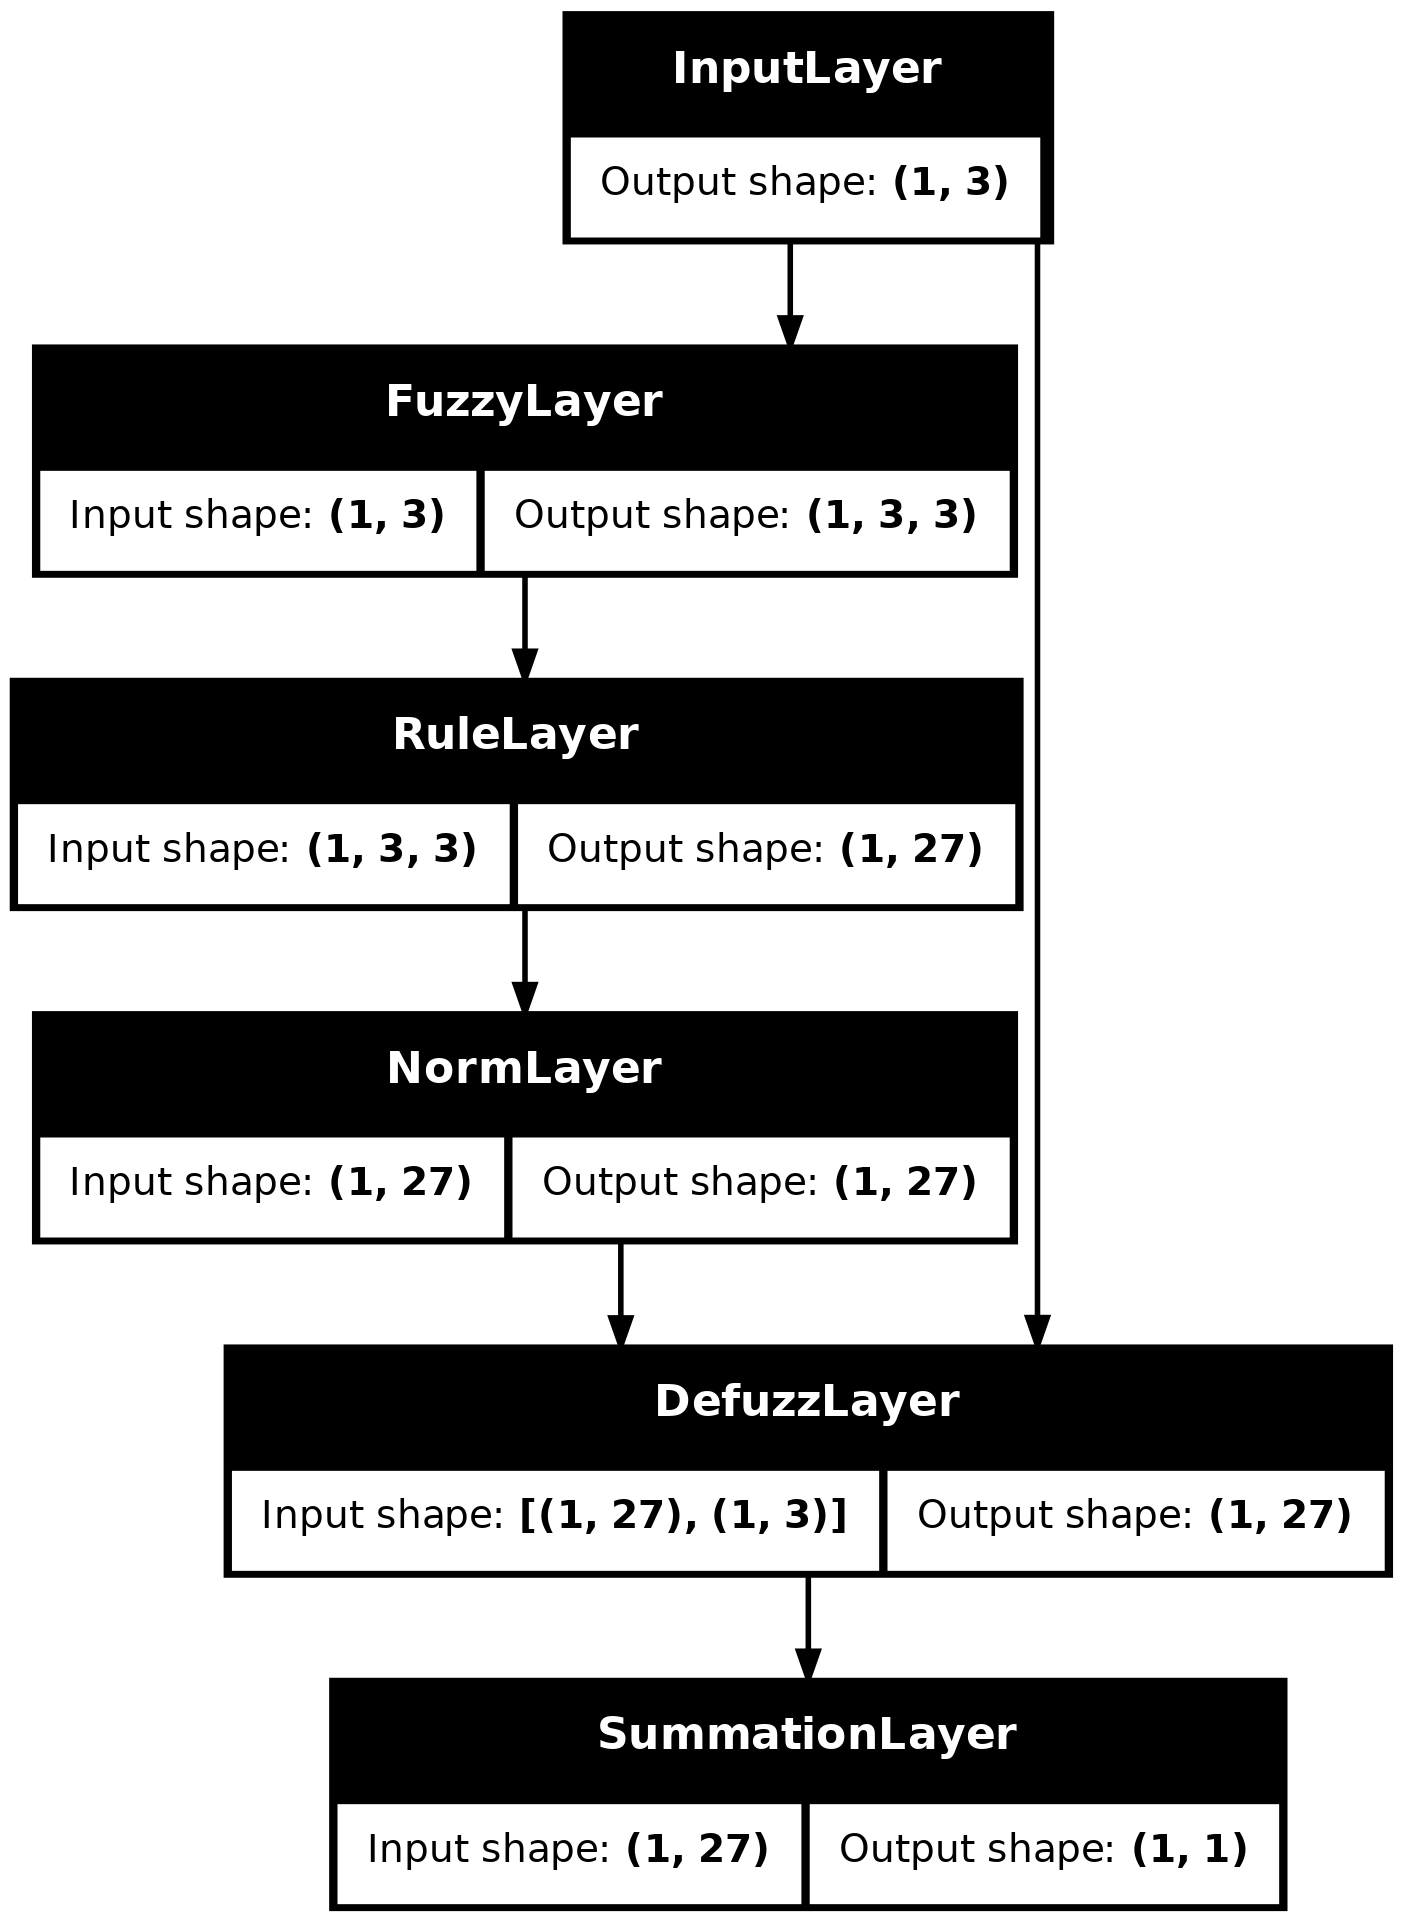

In [24]:
from keras.utils import plot_model


plot_model(fis.model, to_file='multiple_outputs.png',show_shapes=True)

In [25]:
print(X_test.shape)
#y_test=y_test.reshape(42,1)
y_test.shape

#pred= fis.model.predict(X_test)

(42, 3)


(42,)

In [26]:

y_pred = fis(X_test)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step


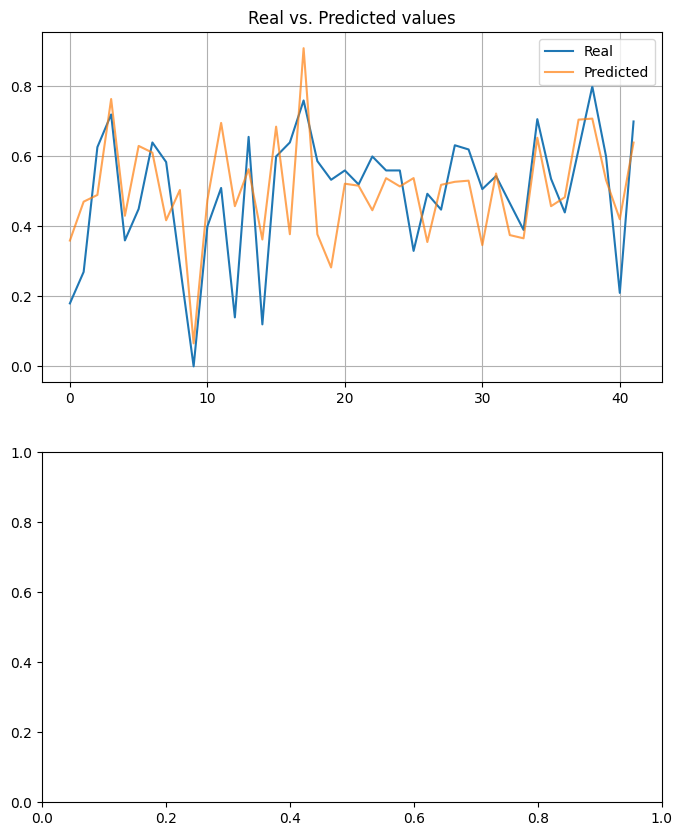

In [27]:
# ## Evaluate Model
# fis.model.evaluate(X_test, y_test)
plot_prediction=True
if plot_prediction:
    y_pred = fis(X_test)
    f, axs = plt.subplots(2, 1, figsize=(8, 10))
    # f.suptitle(f'{gen.get_data_name(data_id)} time series', size=16)
    axs[0].plot(y_test)
    axs[0].plot(y_pred, alpha=.7)
    axs[0].legend(['Real', 'Predicted'])
    axs[0].grid(True)
    axs[0].set_title('Real vs. Predicted values')
    # axs[1].plot(y_test, y_test - y_pred)
    # axs[1].legend(['pred_error'])
    # axs[1].grid(True)
    # axs[1].set_title('Prediction Error')
    plt.show()

In [28]:
y_pred
print(y_pred.shape)
print(y_test.shape)
y_test=y_test.reshape(42,1)
y_test.shape

(42, 1)
(42,)


(42, 1)

In [29]:
print(type(y_pred))

<class 'numpy.ndarray'>


In [30]:
co=np.concatenate((y_test, y_pred),axis=1)
co

array([[0.18      , 0.35962731],
       [0.27      , 0.47074559],
       [0.62666667, 0.48996645],
       [0.72      , 0.76416606],
       [0.36      , 0.43047333],
       [0.45      , 0.630126  ],
       [0.64      , 0.61094284],
       [0.584     , 0.41758937],
       [0.29      , 0.50415272],
       [0.        , 0.06577284],
       [0.4       , 0.47512025],
       [0.51      , 0.69593054],
       [0.14      , 0.45789635],
       [0.656     , 0.56366205],
       [0.12      , 0.36267433],
       [0.6       , 0.68520045],
       [0.64      , 0.37768149],
       [0.76      , 0.90946293],
       [0.58666667, 0.37748483],
       [0.53333333, 0.28276086],
       [0.56      , 0.52211404],
       [0.52      , 0.51639807],
       [0.6       , 0.44620588],
       [0.56      , 0.53795332],
       [0.56      , 0.51438409],
       [0.33      , 0.53813773],
       [0.49333333, 0.35541335],
       [0.448     , 0.518888  ],
       [0.632     , 0.52753478],
       [0.62      , 0.53082478],
       [0.

In [31]:
column_values= ['Real', 'Prediction']
df = pd.DataFrame(data = co,columns = column_values)
df.reset_index(inplace = True)

r2 Score : 0.3757350790925158
MSE Score : 0.020253486416328008
MAE Score : 0.11916593688016845


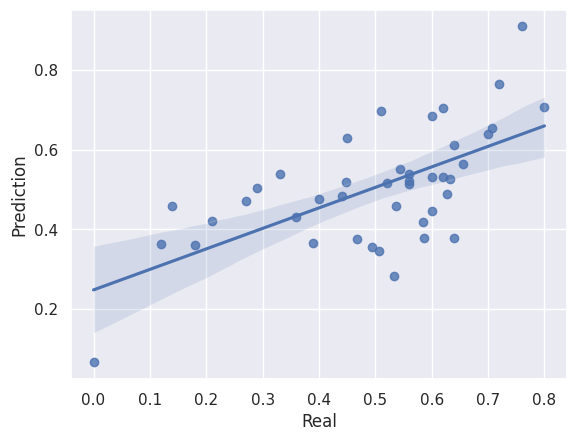

In [32]:
import seaborn as sns

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
print("r2 Score :",r2_score(y_test, y_pred))
print("MSE Score :",mean_squared_error(y_test, y_pred))
print("MAE Score :",mean_absolute_error(y_test, y_pred))

sns.set_theme(color_codes=True)
ax = sns.regplot(x="Real", y="Prediction", data=df)